In [17]:
#!conda install --channel conda-forge cartopy

In [18]:
from datetime import datetime, timedelta
import itertools
from tempfile import NamedTemporaryFile

import boto3
import botocore
from botocore.config import Config
from netCDF4 import Dataset

class GOESArchiveDownloader(object):
    def __init__(self):
        s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED, user_agent_extra='Resource'))
        self._bucket = s3.Bucket('noaa-goes17')

    def _get_iter(self, start, product):
        prod_prefix = str(product)
        start_marker = product.with_start_time(start)
        print(prod_prefix, start_marker)
        return self._bucket.objects.filter(Marker=start_marker, Prefix=str(product))
        
    def get_next(self, time, product):
        return next(iter(self._get_iter(time, product)))

    def get_range(self, start, end, product):
        end_key = product.with_start_time(end)

        # Get a list of files that have the proper prefix up to the hour
        return list(itertools.takewhile(lambda obj: obj.key <= end_key, self._get_iter(start, product)))

#ABI-L1b-RadC/2017/191/21/OR_ABI-L1b-RadC-M3C02_G16_s20171912142189_e20171912144562_c20171912144599.nc
class GOESProduct(object):
    def __init__(self, **kwargs):
        self.sector = 'conus'
        self.satellite = 'goes16'
        self.typ = 'ABI'
        self.channel = 1
        self.mode = 6
        self.datetime = datetime.utcnow()
        self.__dict__.update(kwargs)

    def __str__(self):
        env = 'OR'
        sat = {'goes16': 'G16', 'goes17': 'G17'}[self.satellite]

        if self.typ == 'ABI':
            sector = {'conus': 'C', 'meso1': 'M1', 'meso2': 'M2', 'full': 'F'}[self.sector]
            short_id = 'ABI-L1b-Rad{sector}'.format(sector=sector)
            prod_id = short_id + '-M{mode}C{channel:02d}'.format(mode=self.mode, channel=self.channel)
        elif self.typ == 'GLM':
            short_id = prod_id = 'GLM-L2-LCFA'
        else:
            raise ValueError('Unhandled data type: {}'.format(self.typ))
        return '{short_id}/{datetime:%Y/%j/%H}/{env}_{prodid}_{sat}'.format(short_id=short_id, datetime=self.datetime,
                                                                   env=env, prodid=prod_id, sat=sat)

    __repr__ = __str__

    def with_start_time(self, time):
        return str(self) + '_s{time:%Y%j%H%M%S}'.format(time=time)

In [19]:
arc = GOESArchiveDownloader()

In [20]:
start = datetime(2020, 7, 10, 20)
arc.get_range(start, start + timedelta(minutes=30), GOESProduct(satellite='goes17', typ='ABI', channel=2, sector='conus', datetime=start))

ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17 ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s2020192200000


[s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922001177_e20201922003550_c20201922003572.nc'),
 s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922006177_e20201922008550_c20201922008571.nc'),
 s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922011177_e20201922013550_c20201922013572.nc'),
 s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922016177_e20201922018550_c20201922018575.nc'),
 s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922021177_e20201922023550_c20201922023574.nc'),
 s3.ObjectSummary(bucket_name='noaa-goes17', key='ABI-L1b-RadC/2020/192/20/OR_ABI-L1b-RadC-M6C02_G17_s20201922026177_e20201922028550_c20201922028572.nc')]

In [21]:
dt = datetime(2020, 7, 11, 19, 0, 0)
obj = arc.get_next(dt, GOESProduct(satellite='goes17', typ='ABI', channel=2, sector='conus', datetime=dt))

ABI-L1b-RadC/2020/193/19/OR_ABI-L1b-RadC-M6C02_G17 ABI-L1b-RadC/2020/193/19/OR_ABI-L1b-RadC-M6C02_G17_s2020193190000


In [22]:
nc = Dataset(None, memory=obj.get()['Body'].read())

In [25]:
#nc

/Users/nimrashakoor/opt/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/nimrashakoor/opt/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


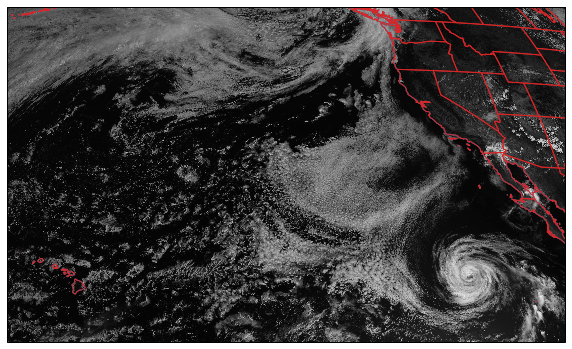

In [36]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

data = nc.variables['Rad'][:]

fig = plt.figure(figsize=(10,10))
proj_var = nc.variables['goes_imager_projection']
globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                          satellite_height=proj_var.perspective_point_height, globe=globe)
ax = fig.add_subplot(1, 1, 1, projection=proj)

x = nc.variables['x'][:] * proj_var.perspective_point_height
y = nc.variables['y'][:] * proj_var.perspective_point_height
ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()), cmap='Greys_r', origin='upper')
ax.coastlines('10m', color='tab:blue')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='tab:red')